In [1]:
import pandas as pd
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Set-up Model Parameters

In [1]:
# load mobility matrix
data = pd.read_csv('../../../Dropbox/Epidemiology/trajectories/nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=1)

NameError: name 'pd' is not defined

In [ ]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5)
tmat.add_transition('A', 'I', 3)
tmat.add_transition('I', 'R', 14)
print(tmat.value)
np.sum(tmat.value, axis=1)

In [4]:
# starting fractions means
start = np.zeros((M, C))
start[:,compartments.index('I')] = 0.1

## Make starting joint

In [5]:
param_model = maxentep.parameter_joint(start, R, tmat.value, 0.2, name='unbiased')
param_joint = param_model(tf.constant([1.]))

## Examine some of the statistics

In [6]:
param_joint[1].sample(1)

<tf.Tensor: shape=(1, 7, 4), dtype=float32, numpy=
array([[[9.6155310e-01, 3.8446918e-02, 1.3896341e-39, 1.3896341e-39],
        [1.5582887e-39, 6.0864210e-01, 3.9135796e-01, 1.5582887e-39],
        [3.2298010e-39, 3.2298010e-39, 9.6619242e-01, 3.3807565e-02],
        [2.7868674e-39, 2.7868674e-39, 2.7868674e-39, 1.0000000e+00],
        [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
        [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
        [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01]]],
      dtype=float32)>

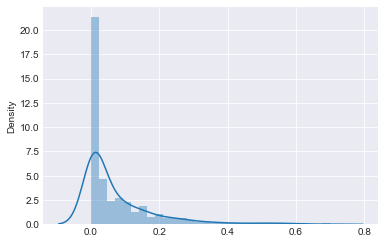

In [7]:
x = param_joint[1].sample(500)[:,compartments.index('I'), compartments.index('R')].numpy()
sns.distplot(x=x)
plt.show()

In [ ]:
# check transition matrix is valud
T = param_joint[1].sample(1)[0].numpy()
f = [0.8,0,0,0]
for i in range(10):
    f = f @ T
    print(f, np.sum(f))


## Create set of trajectories
The loop is just to batch the trajectories. It is not necessary, just I have my at home GPU which has small RAM.
You could instead just pick `N = 16 * 256` and call once.

In [ ]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 256
batches = 1
outs = []
timesteps = 1000
infect_fxn = maxentep.contact_infection_func(infections_compartments)
model = MetaModel(infect_fxn, timesteps)
for b in tqdm.tqdm(range(batches)):
    psample = [j.sample(N) for j in param_joint]
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

In [ ]:
# plot a few trajectories
fig, ax = plt.subplots(3, 3, figsize=(12,8))
for i in range(3):
    for j in range(3):
        ax[i,j].plot(trajs[i * 3 + j,:,0,:])
plt.show()

## Make quantile Plots

In [ ]:
full_compartments = ['S'] + compartments
traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True)
plt.ylim(0,0.2)
plt.show()

## Create arbitrary restraints

In [ ]:
restraints = np.array([
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,900, 1, 4],
    [0.6, 0.1, 250, 34, 4],
    [0.4, 0.1, 250, 24, 0],
             ])
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i, 2:].astype(np.int))
    value = restraints[i, 0]
    uncertainty = restraints[i, 1]
    p = maxentep.Laplace(uncertainty)
    #p = maxentep.EmptyPrior()
    r = maxentep.Restraint(lambda traj,j=traj_index: traj[j], value, p)
    laplace_restraints.append(r)

## Use maxent model to fit

In [ ]:
model = maxentep.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Nadam(learning_rate=1e-2), 'mean_squared_error')

In [ ]:
history = model.fit(trajs, batch_size=16, epochs=10, verbose=0)

In [ ]:
model.summary()

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
weights = model.traj_weights
plt.hist(weights)
plt.show()
plt.plot(model.lambdas.numpy(), 'o')

## Complete patch plots
disable if you want, they are very slow

In [ ]:
patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

In [ ]:
patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

## Final plots showing agreement

In [ ]:
for p in [0,1,2,34,24]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()